# Install and import

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

fatal: destination path 'AdversarialRegularization' already exists and is not an empty directory.


In [ ]:
from AdversarialRegularization.utils import *

# Loading Models

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

We want to collect good filters. For that purpose, we load models that have been trained on a large dataset. These models differ only in initial weight initialization.

In [ ]:
model_dir = 'AdversarialRegularization/models/'
model_lst = []

for model_name in os.listdir('AdversarialRegularization/models/'):
    model_path = os.path.join(model_dir, model_name)
    model = CNN(num_classes=100)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_lst.append(model)

In [ ]:
print('Number of models:', len(model_lst))

Number of models: 5


# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [ ]:
class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [ ]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

In [ ]:
filters_data = []
filters_loader = []

# Create datasets for 7x7, 5x5, 5x5 kernels from corresponding convolution layers 
filters_data.append(FilterDataset([model.features[0] for model in model_lst]))
filters_data.append(FilterDataset([model_lst[0].features[3]]))
filters_data.append(FilterDataset([model_lst[0].features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data)):
    filters_loader.append(DataLoader(filters_data[i], batch_size=128, shuffle=True))

In [ ]:
for i in range(len(filters_loader)):
    print(f'Filter Dataset {i} size: {len(filters_loader[i].dataset)}')

Filter Dataset 0 size: 960
Filter Dataset 1 size: 8192
Filter Dataset 2 size: 16384


Now, we can iterate over filters dataset.

We can also visualize kernels to check if our dataset contains patterns.

In [ ]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    grid = grid.to(device=torch.device("cpu")) 
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='coolwarm')

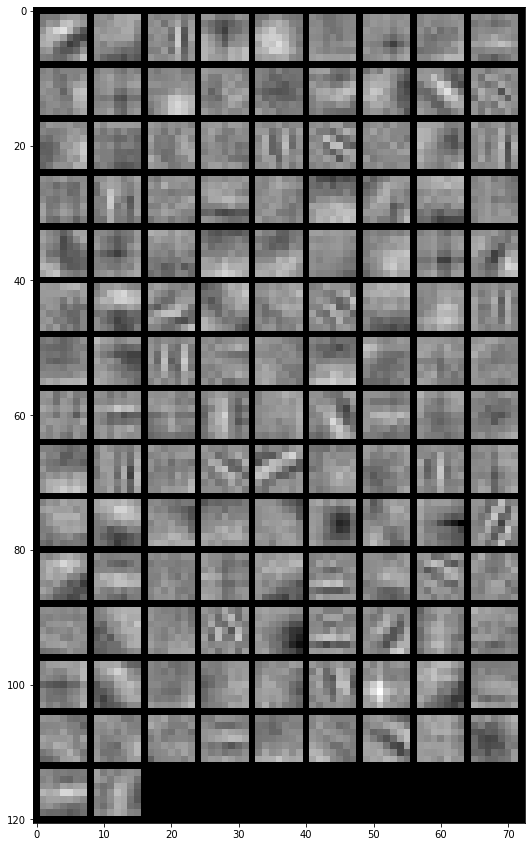

In [ ]:
plot_kernels(filters_loader[0], nrow=9)

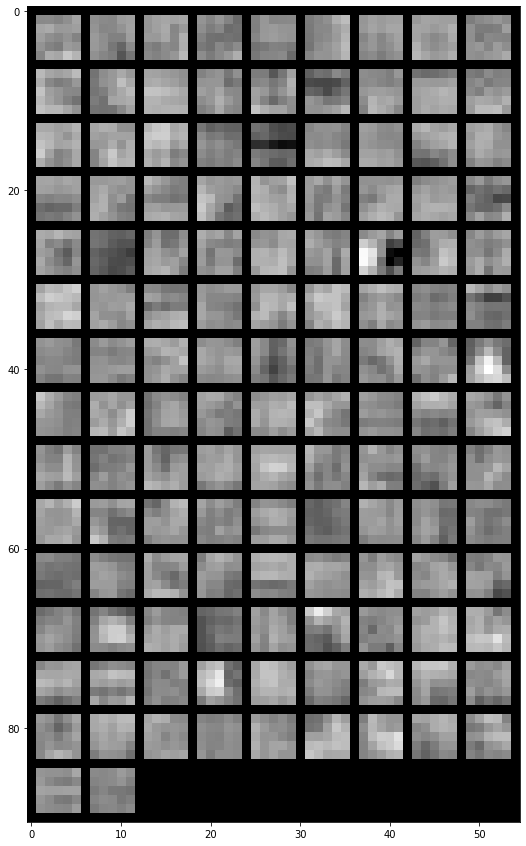

In [ ]:
plot_kernels(filters_loader[1], nrow=9)

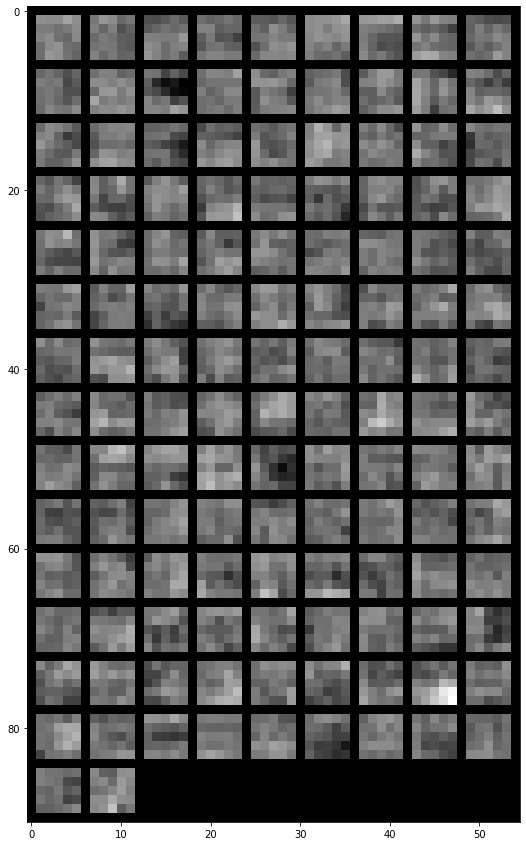

In [ ]:
plot_kernels(filters_loader[2], nrow=9)

# Prepare data

Now we load CIFAR10 and take a small subset of it. We restrict this subset to have equal number of images per class to make dataset balanced.

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5)])

train_set = torchvision.datasets.CIFAR10('./cifar10', train=True, download=True,
                                         transform=train_transform)

test_set = torchvision.datasets.CIFAR10('./cifar10', train=False, download=True,
                                        transform=test_transform)

print('Train size', len(train_set))
print('Test size', len(test_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Train size 50000
Test size 10000


In [ ]:
train_size = 100 / len(train_set)

In [ ]:
train_idx, _ = train_test_split(np.arange(len(train_set)),
                                train_size=train_size,
                                shuffle=True,
                                random_state=42,
                                stratify=train_set.targets)

Let's make sure that the obtained indices are indeed stratified by classes.

In [ ]:
pd.DataFrame(train_set.targets).rename(columns={0: 'class'}).iloc[train_idx].groupby('class').size()

class
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
dtype: int64

In [ ]:
train_set = Subset(train_set, train_idx)

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

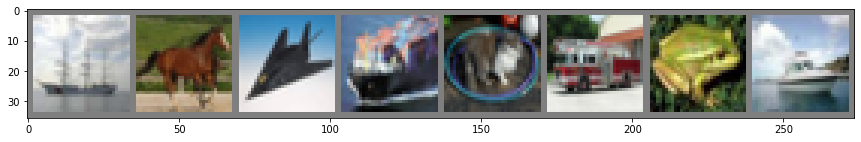

In [ ]:
plot_random_images(train_loader)

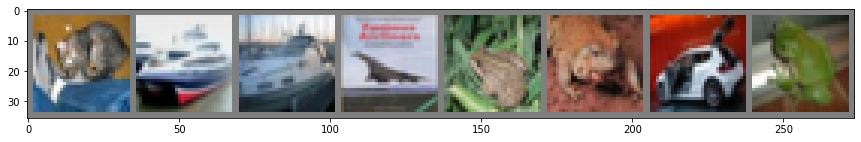

In [ ]:
plot_random_images(test_loader)

# Training on small dataset

In [ ]:
def epoch_train(loader, clf, criterion, opt):
    clf.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        loss = criterion(output, target)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
    clf.eval()
    train_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            train_loss += criterion(output, target).item()
    train_acc = get_accuracy(clf, loader, device)
    train_loss /= len(loader.dataset)
    return train_loss, train_acc


def epoch_test(loader, clf, criterion):
    clf.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            test_loss += criterion(output, target).item()
    test_acc = get_accuracy(clf, loader, device)
    test_loss /= len(loader.dataset)
    return test_loss, test_acc


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    test_scores = []
    for epoch in range(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        if epoch % 10 == 9:
            test_loss, test_acc = epoch_test(test_loader, clf, criterion)
            test_scores.append(test_acc)
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')
    return test_scores

In [ ]:
torch.cuda.set_device(0)
clf = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10

Number of weights: 922442


In [ ]:
opt_clf = torch.optim.Adam(clf.parameters(), lr=2e-4, weight_decay=1e-4, betas=(0.5, 0.999))
criterion = torch.nn.CrossEntropyLoss()
test_scores = train(train_loader, test_loader, clf, criterion, opt_clf, n_epochs=1000)

[Epoch 10] train loss: 0.016; train acc: 1.00; test loss: 0.135; test acc: 0.20
[Epoch 20] train loss: 0.005; train acc: 1.00; test loss: 0.135; test acc: 0.22
[Epoch 30] train loss: 0.003; train acc: 1.00; test loss: 0.139; test acc: 0.20
[Epoch 40] train loss: 0.001; train acc: 1.00; test loss: 0.137; test acc: 0.21
[Epoch 50] train loss: 0.002; train acc: 1.00; test loss: 0.142; test acc: 0.21
[Epoch 60] train loss: 0.001; train acc: 1.00; test loss: 0.139; test acc: 0.20
[Epoch 70] train loss: 0.001; train acc: 1.00; test loss: 0.141; test acc: 0.20
[Epoch 80] train loss: 0.001; train acc: 1.00; test loss: 0.143; test acc: 0.20
[Epoch 90] train loss: 0.002; train acc: 1.00; test loss: 0.143; test acc: 0.20
[Epoch 100] train loss: 0.000; train acc: 1.00; test loss: 0.144; test acc: 0.21
[Epoch 110] train loss: 0.001; train acc: 1.00; test loss: 0.153; test acc: 0.17
[Epoch 120] train loss: 0.001; train acc: 1.00; test loss: 0.150; test acc: 0.19
[Epoch 130] train loss: 0.001; train 

In [ ]:
filters_data_small = []
filters_loader_small = []
# Create datasets for 7x7, 5x5, 5x5 kernels from corresponding convolution layers 
filters_data_small.append(FilterDataset([clf.features[0]]))
filters_data_small.append(FilterDataset([clf.features[3]]))
filters_data_small.append(FilterDataset([clf.features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data_small)):
    filters_loader_small.append(DataLoader(filters_data_small[i], batch_size=128, shuffle=True))

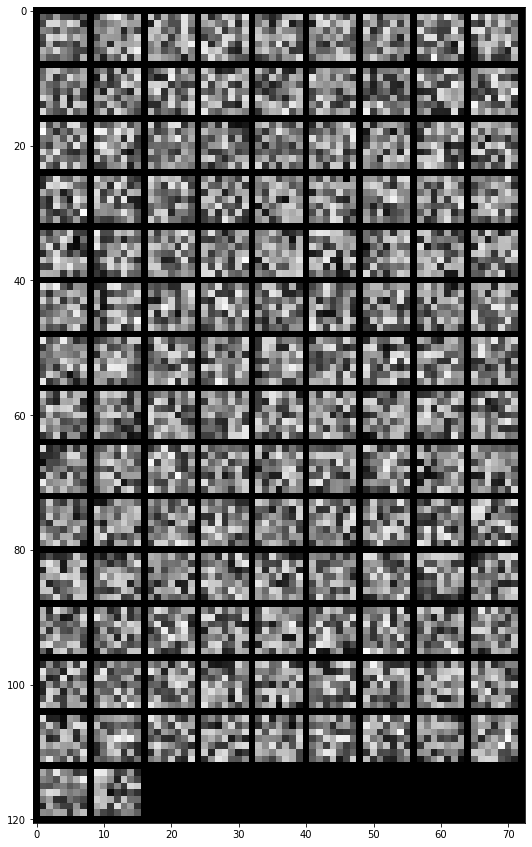

In [ ]:
plot_kernels(filters_loader_small[0], nrow=9)

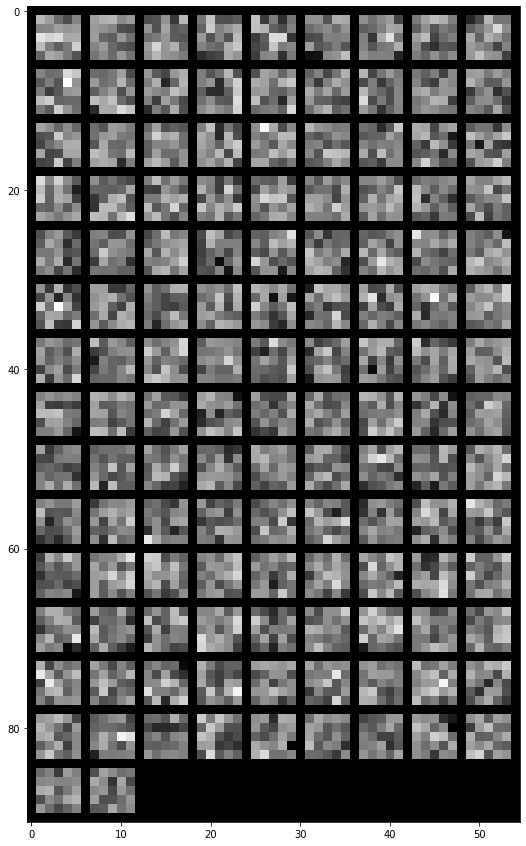

In [ ]:
plot_kernels(filters_loader_small[1], nrow=9)

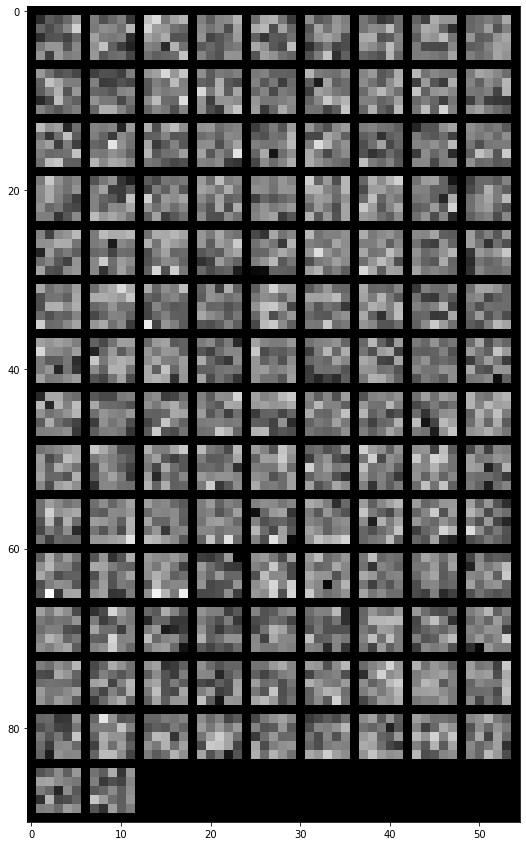

In [ ]:
plot_kernels(filters_loader_small[2], nrow=9)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


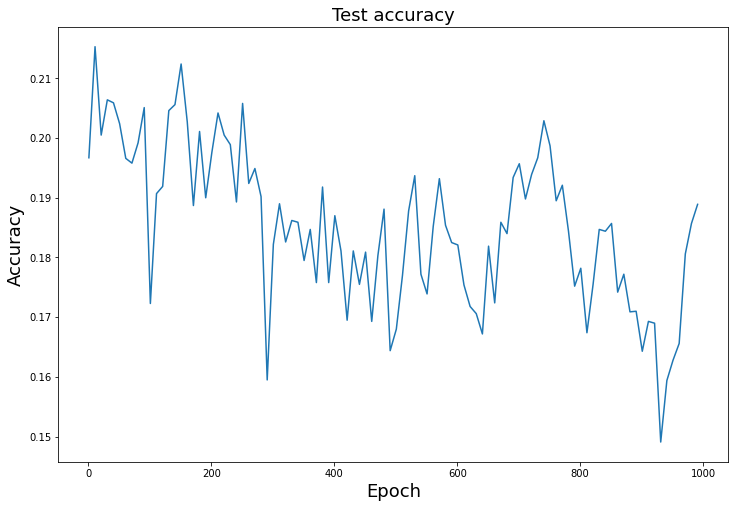

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 1001, 10), test_scores)
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.title('Test accuracy', size=18)
plt.show()
plt.savefig('plot.png')